#### Setup

In [92]:
#import pdb; pdb.set_trace()

%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import json
import psycopg2
from sqlalchemy.engine.url import URL

# connection to the database
# connection string for use in pandas:
con = str(URL(drivername='postgresql', 
              username=os.environ['DB_QIR_USERNAME'], 
              password=os.environ['DB_QIR_PASSWORD'], 
              host='www.quantleap.nl', 
              database='qir'))

# cursor for use with psycopg2
conn = psycopg2.connect(con)
cur = conn.cursor()  
print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


# Report data set description

The data set used in this study contains all the PDF reports published in 2017.

There are two types of reports: 
1. progress reports, containing text based on a RECOFA template
2. financial reports, containing tables - [todo: determine conformance with RECOFA template]

Most often [todo: measure] the financial reports are attached to a progress report: both are published on the same date and the identification number is equal, only the financial report has '\_B' as a postfix.

Initially we will be focussing on the progress reports as these have more structure and contain more of the data we want to retreive to answer the research questions.

## report publication over time
An overview is given on the published reports over time in the CIR register. From 2014 onwards it shows a steady flow of reports and the trend of a larger portion of financial reports attached to the progress reports, although it has not reached 100% (same amount of both progress and financial reports).

For the purpose of this study the progress reports published in 2017 will be used.

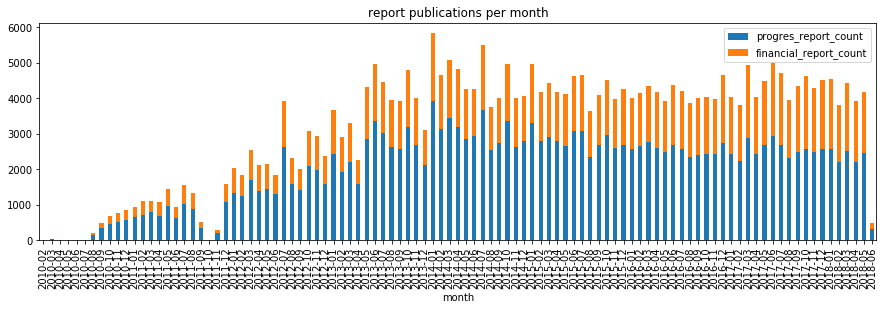

In [124]:
sql = """
with
financial as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as financial_report_count
      from reports
      where is_attachment is True
      group by 1),
progress as (
      select to_char(publication_date, 'YYYY-MM') as month,
             count(*) as progres_report_count
      from reports
      where is_attachment is False
      group by 1)
select prog.month, progres_report_count, coalesce(financial_report_count, 0) as financial_report_count
  from financial fin
    full outer join progress prog on fin.month = prog.month
  order by prog.month;
"""
df = pd.read_sql(sql, con, index_col="month")
df.plot.bar(stacked=True, figsize=(15, 4), title='report publications per month')

# Completeness checks
A subselection of the published reports will be used for analysis:
- reports from 2017
- downloaded PDF reports (some cannot be downloaded anymore)
- converted instead of scanned PDFs 
- reports with extracted text (some PDF reports are encrypted or damaged (absent End of Image / End of File) and text cannot be extracted)

## PDF reports downloaded

In [133]:
sql = """select identification, is_ocr, is_on_disk, publication_date, is_extractable
         from reports rep join insolvents ins on rep.insolvent_id = ins.id
         where publication_date >= '2014-01-01'
             and publication_date) <= 2018-06-
             and is_attachment=False;"""
             #and ins.is_removed=False;"""
             #and (end_findability ISNULL or end_findability >= '2017-12-31');"""
    
df = pd.read_sql(sql, con, index_col='publication_date')

print('The dataset to be used contains {} progress reports in period 2014 - 2017'.format(len(df)))
df.head()

The dataset to be used contains 132457 progress reports in period 2014 - 2017


,identification,is_ocr,is_on_disk,is_extractable
publication_date,,,,
2016-03-16 10:05:39,13_ams_15_179_F_V_05,False,True,True
2014-07-11 16:37:06,05_gel_13_1149_F_V_03,False,True,True
2017-12-04 12:15:25,09_dha_13_781_F_V_18,False,True,True
2014-10-09 09:27:09,02_zwb_11_748_F_V_04,True,True,True
2016-04-07 17:01:24,10_rot_13_747_F_V_08,True,True,True


## Report extraction funnel

In [134]:
# Funnel of searchable reports (later the contraint of being txt_type report can be dropped)
sample_freq = 'QS'
total_serie = df['identification'].resample(sample_freq).count().rename('total')

# on disk
on_disk_serie = df[df.is_on_disk == True].is_on_disk.resample(sample_freq).count().rename('on_disk')
not_on_disk_serie = (total_serie - on_disk_serie).rename('not_on_disk')

# report type
and_img_type_serie = df[(df.is_on_disk == True) & (df.is_ocr == True)].is_ocr.resample(sample_freq).count().rename('and_img')
and_txt_type_serie = df[(df.is_on_disk == True) & (df.is_ocr == False)].is_ocr.resample(sample_freq).count().rename('and_txt')
and_unk_type_serie = (on_disk_serie - and_img_type_serie - and_txt_type_serie).rename('and_unk')

# extracted content
and_is_extractable_serie = df[(df.is_on_disk == True) & (df.is_extractable == True)].is_extractable.resample(sample_freq).count().rename('and_extractable')
and_is_not_extractable_serie = (on_disk_serie - and_is_extractable_serie).rename('and_not_extractable')

pd.concat([total_serie, 
           not_on_disk_serie, on_disk_serie,
           and_unk_type_serie, and_img_type_serie, and_txt_type_serie,
           and_is_not_extractable_serie, and_is_extractable_serie], axis=1)

,total,not_on_disk,on_disk,and_unk,and_img,and_txt,and_not_extractable,and_extractable
publication_date,,,,,,,,
2014-01-01,10502,1,10501,200,6238,4063,287,10214
2014-04-01,8982,0,8982,275,5221,3486,432,8550
2014-07-01,8949,0,8949,217,4904,3828,338,8611
2014-10-01,8786,4,8782,174,4860,3748,303,8479
2015-01-01,8999,0,8999,101,4785,4113,218,8781
2015-04-01,8512,0,8512,156,4498,3858,254,8258
2015-07-01,8091,3,8088,154,4072,3862,265,7823
2015-10-01,8251,0,8251,120,3868,4263,219,8032
2016-01-01,7971,40,7931,154,3136,4641,210,7721


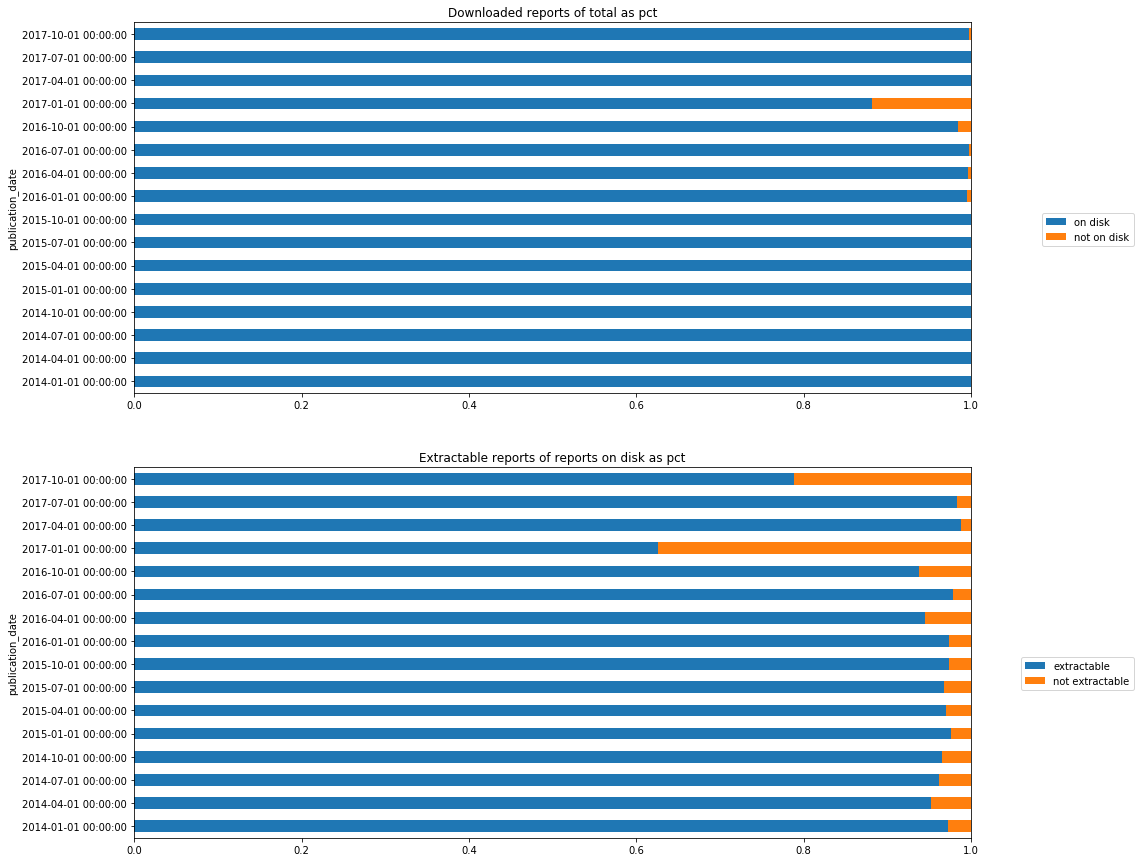

In [141]:
# plot funnel
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(15, 15)

# percentage of available/downloaded reports
ax = pd.concat([(on_disk_serie / total_serie).rename('on disk'),
                (not_on_disk_serie / total_serie).rename('not on disk')], axis=1)  \
                 .plot.barh(ax=axes[0], stacked=True, title='Downloaded reports of total as pct', xlim=[0,1]) \
                 .legend(bbox_to_anchor=(1.2, 0.5))

ax = pd.concat([(and_is_extractable_serie / on_disk_serie).rename('extractable'),
                (and_is_not_extractable_serie / on_disk_serie).rename('not extractable')], axis=1)  \
                 .plot.barh(ax=axes[1], stacked=True, title='Extractable reports of reports on disk as pct', xlim=[0,1]) \
                 .legend(bbox_to_anchor=(1.2, 0.5))



### Result
The deviations must be investigates:
- missing reports jan 2017 were not downloaded and later retracted by CIR due to end findability of cases.
- unextractable reports Q4 2017 are not explained yet.

Most PDF reports can be extracted. One found cause for some of the remaining:
- some downloaded reports appear to be empty, 0kb. Something went wrong during downloading. These files must be

## PDF Conversion of progress reports on disk

PDFs can be generated by:
1. scanning printed pages - resulting in an image only document, 
2. converting a document to PDF - resulting in a text only document
3. scanning printed pages with OCR (Optical Character Recognition) - resulting in a text and image document

The latter one can have discrepancies between the visible text and extracted text.

### adoption of conversion software over scanner over time
Content extraction of PDFs created with conversion software is more accurate and much faster than conversion using OCR from scanned PDFs. We can assume in general that searches of recent and future reports will be more accurate than older reports.

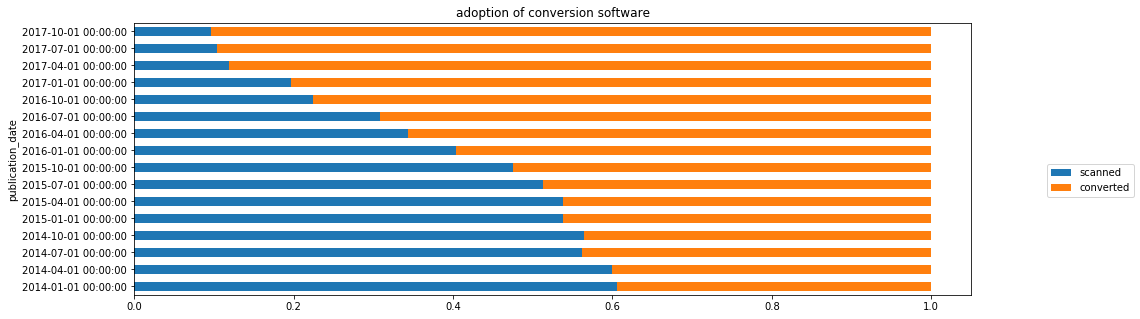

In [145]:
pd.concat([(and_img_type_serie/(on_disk_serie - and_unk_type_serie)).rename('scanned'),
           (and_txt_type_serie/(on_disk_serie - and_unk_type_serie)).rename('converted')], axis=1) \
.plot.barh(stacked=True, title='adoption of conversion software', figsize=[15, 5]).legend(bbox_to_anchor=(1.2, 0.5))

## Search in progress reports.

There are three progress report search objectives, each more scoped: 
1. to enable full text search over the whole report
2. to enable faceted search by subheading section
3. to extract specific data points as value. 

### Full Text Search
The extracted contents is made searchable using the postgres full text search functionality. (https://www.postgresql.org/docs/9.6/static/textsearch.html)

### Faceted search
The progress reports should be structured in sections according to RECOFA guidelines, see **model-verslag-faillissement-rechtspersoon.pdf**. We like to be able to extract the sub heading sections to 1. perform full text search in one of the sub sections and 2. to narrow down the field of interest for futher extraction and analysis.

### data points wish list
We like to extract specific data point values from the report sub sections. A wish list is given below:

Algemeen
- Personeel gemiddeld aantal: **aantal**
- Bestede uren totaal: **aantal**
- Saldo boedelrekening: **bedrag**

1.7 Oorzaak faillissement

_4 Debiteuren_

4.2 Opbrengst: **bedrag**

_5 Bank / Zekerheden

5.1 Vordering van bank(en): **wel/niet** en **bedrag**

_7 Rechtmatigheid_

7.2 Depot jaarrekeningen: **wel/niet**

7.5 Onbehoorlijk bestuur: **wel/niet**

7.6 Paulianeus handelen: **wel/niet**

_8 Crediteuren_

8.1 Boedelvorderingen: bedrag (salaris curator / UWV / ..)

8.2 Preferente vorderingen van de fiscus: **bedrag**

8.3 Preferente vorderingen van het UWV: **bedrag**

8.4 Andere preferente vorderingen: **bedrag**

8.5 Aantal concurrente crediteuren: **aantal**

8.6 Bedrag concurrente crediteuren: **bedrag**

#### Enige terloopse bevindingen en issues
- Bij insolventen van verslagen 13_ams_15_478_F_V_06 en 10_rot_12_90_F_V_16 zijn geen enkele financiele verslagen ook curator salaris wordt niet genoemd. Vraag: wie levert geen financieel verslag en waarom?
- Bij eindverslag 10_rot_14_1054_F_V_10 staat curator salaris alleen in de financiele bijlage. Er lijkt ook sprake van een schikking - regeling bestuurder: 22.000 - wegens rechtmatigheidsissue. 
- bij 11_rot_12_41_F_V_15 staan bedragen doorgestreept, textconversie pakt dat niet
- De eindverslagen zijn niet echt eindverslagen: 'Naar verwachting zal het faillissement in de komende
verslagperiode eindigen.' (11_rot_12_41_F_V_15)
- uurtarief bij 11_rot_12_41_F_V_15 komt op 280,-
- 10_rot_14_1054_F_V_10, 01_obr_13_293_F_V_09 omzetting pdf>txt verliest letters/gegevens/structuur met PDFMiner. Welke converter pakt dit goed aan ?
- Strikethrough in PDF komt niet terug in de tekstconversie en dit betekent vaak het tegenovergestelde.
- PDFMiner wisselt soms woordvolgorde en mangled soms letters ook al staat dit duidelijk in het PDF. Dit komt door het formaat: text plus image overlay.
- PyPDF2 hangt op grote images (voorbeelden '16_mne_13_935_F_V_13', '16_mne_13_1055_F_V_13', '16_mne_12_331_F_V_15', '16_mne_12_326_F_V_15', '16_mne_12_327_F_V_15,' '16_mne_12_384_F_V_15') - een pull request #329 fixt dit.
- Toezichtzaaknummer. Deze zit niet in de CIR webservice data maar is wel online in de zaak details te vinden: https://insolventies.rechtspraak.nl/#!/details/09.dha.18.3.F.1328.1.18

### Faceted search - section extraction
The RECOFA model progress report contains the following sections to be extracted:

Step 1: extract section anchor points from progress reports, the level 2 headings
To extract the introduction we can extract between the beginning and level 1 heading 1.

Step 2: extract candidate sections from model report

In [31]:
# Define data set
sql = '''SELECT identification, content
         FROM reports 
         WHERE extract(year from publication_date) >= 2014
             AND extract(year from publication_date) <= 2017
             AND is_attachment = FALSE
             AND is_ocr = FALSE 
             AND is_extractable = TRUE
             AND content IS NOT NULL
         ORDER BY publication_date ASC
         LIMIT 200;'''
df = pd.read_sql(sql, con, index_col='identification')
df.head(n=10)

,content
identification,
17_nne_13_346_F_V_01,Naam faill Voercentrum Dokkum BV \nC 17/13/346...
17_nne_13_344_F_V_01,Naam faill Voercentrum Grondstoffen BV \nC 17/...
17_nne_13_345_F_V_01,Naam faill Voercentrum Franchise BV \nC 17/13/...
17_nne_13_343_F_V_01,Naam faill Voercentrum BV \nC 17/13/343 F \n \...
17_nne_13_98_F_V_04,Winkel \n\nadvocatenkantoor \n\n nummer: 4 ;...
17_nne_13_342_F_V_01,\n\n Nummer: 1 \n\n Datum: 27 dece...
08_ove_13_352_F_V_03,\n\n \n \n\nFAILLISSEMENTSVERSLAG - 03 \n\nop...
10_rot_13_931_F_V_02,Borsboom & Hamm \n\na d v o c a t en \n\nHet p...
03_lim_13_41_F_V_02,\n \n \n \n\nmr M.T.A.C. Russel \nde heer P.E...


In [32]:
# Step 1: extract section anchor points from progress reports
# Sub step: extract candidate sections from model report
model_content = open('model-verslag-faillissement-rechtspersoon.txt', 'r').read()

def match_headings(content, level=2):
    """ returns level 2 (e.g. 1.1) heading matches as tuple (heading number, heading title)"""
    flags = re.MULTILINE
    if level == 2:
        pattern = r"^\s*(\d{1,2}\.\d{1,2})\s*(.*)$"
    elif level == 12:  # level 1 and level 2
        pattern = r"^\s*(\d{1,2}\.\d{0,2})\s*(.*)$"
    else:
        raise NotImplementedError
    match = re.findall(pattern, content, flags)
    return match if match is not None else []

model_headings = [('0.0', 'Introduction')] + match_headings(model_content, level=2)
model_heading_numbers = list(zip(*model_headings))[0]
print(len(model_headings))
model_headings

73


[('0.0', 'Introduction'),
 ('1.1', 'Directie en organisatie'),
 ('1.2', 'Winst en verlies'),
 ('1.3', 'Balanstotaal'),
 ('1.4', 'Lopende procedures'),
 ('1.5', 'Verzekeringen'),
 ('1.6', 'Huur'),
 ('1.7', 'Oorzaak faillissement'),
 ('2.1', 'Aantal ten tijde van faillissement'),
 ('2.2', 'Aantal in jaar voor faillissement'),
 ('2.3', 'Datum ontslagaanzegging'),
 ('2.4', 'Werkzaamheden'),
 ('3.1', 'Beschrijving'),
 ('3.2', 'Verkoopopbrengst'),
 ('3.3', 'Hoogte hypotheek'),
 ('3.4', 'Boedelbijdrage'),
 ('3.5', 'Werkzaamheden'),
 ('3.6', 'Beschrijving'),
 ('3.7', 'Verkoopopbrengst'),
 ('3.8', 'Boedelbijdrage'),
 ('3.9', 'Bodemvoorrecht fiscus'),
 ('3.10', 'Werkzaamheden'),
 ('3.11', 'Beschrijving'),
 ('3.12', 'Verkoopopbrengst'),
 ('3.13', 'Boedelbijdrage'),
 ('3.14', 'Werkzaamheden'),
 ('3.15', 'Beschrijving'),
 ('3.16', 'Verkoopopbrengst'),
 ('3.17', 'Werkzaamheden'),
 ('4.1', 'Omvang debiteuren'),
 ('4.2', 'Opbrengst'),
 ('4.3', 'Boedelbijdrage'),
 ('4.4', 'Werkzaamheden'),
 ('5.1', 'Vo

In [33]:
# Example (first) report
report_content = df['content'][0]
report_headings = match_headings(report_content, level=12)  # match level 2 headings
report_heading_numbers = list(zip(*report_headings))[0]
print(report_content)
print(report_headings)

Naam faill Voercentrum Dokkum BV 
C 17/13/346 F 
 

 

      Nummer: 1   

     Datum: 27 december 2013 

FAILLISSEMENTSVERSLAG       
 
 
In dit verslag  worden  de  werkzaamheden en de stand van de boedel beschreven  over de afgelopen 
periode.  De  curator  baseert  zich  op  aangetroffen  gegevens  en  informatie  van  derden.  De  juistheid 
daarvan  staat  thans  nog  niet  vast,  zodat  mogelijkerwijs  gegevens  en  cijfers  in  een  later  stadium 
aanpassing  behoeven.  Aan  dit  verslag  kunnen  geen  rechten  worden  ontleend.  De  inhoud  van  de 
papieren versie is identiek aan de digitale versie. 
 
 
Gegevens gefailleerde 

: 

 

de  besloten  vennootschap  VOERCENTRUM  DOKKUM 
B.V. (hierna: “de vennootschap”) 
 
Statutair en vestigingsadres: 
Neptunusweg no. 5 
8938 AA  Leeuwarden 

 

 

 
 
 
 

 
 
 
 
 

 
 
 
 
  
 
 
 
 
 
 
Faillissementsnummer 
Datum uitspraak 
Curator  
 
 
 
 
Rechter-commissaris 
 
Activiteiten onderneming 

 
 
 
 

 
 
 
 
 

Correspondent

In [34]:
# SECTIONS
# check hoeveel er exact matchen(ignore case)
# check hoeveel er op heading nummers matchen
# for stop anchor point we need to level 1 headings too

# ZOU MATCH OP HEADING NUMMER AL GENOEG KUNNEN ZIJN ? :
# check of heading nummers oplopen
# check of heading nummers in kandidatenlijst voorkomen

# level 1 pattern with .? yields many false positives (in first examined case)

def is_strictly_increasing_heading_numbers(heading_numbers):
    """ checks if all level 2 headings 1.1, 1.2, 3.1 etc in list are strictly increasing. """
    return all([float(a) < float(b) for (a, b) in zip(heading_numbers, heading_numbers[1:])])

def has_only_model_heading_numbers(report_heading_numers):
    """ checks if report heading numbers are all present in the model heading numbers. """
    return set(report_heading_numers) <= set(model_heading_numbers)

def get_heading_numbers(content):
    headings = match_headings(content)
    if headings:
        heading_numbers, _ = list(zip(*headings))
        return heading_numbers
    else:
        return []
  
def model_heading_coverage(report_heading_numbers):
    """ return the number of headings found as percentage of the model report. """
    pass

In [35]:
%run progress_report_extractor
report_content = df['content'][0]
print(extract_section(report_content, '7.6'))  # paulianeus handelen


Paulianeus handelen 
Op 16 juni 2011 heeft De Koning, de onderneming van Billabong (goodwill, handelsnaam, 
voorraden en exploitatierechten) gekocht voor een bedrag van € 120.000. Op 12 maart 2012 
heeft De Koning de hele onderneming van Billabong (goodwill en inventaris) weer verkocht aan 
een derde voor een bedrag van € 90.000. De curator  heeft deze verkoop onderzocht en is tot 
de conclusie gekomen dat er geen sprake is van paulianeus handelen.  
 
 
 
 
 


 
 
Tot op heden is van paulianeus handelen niet gebleken. 
 
 
 
In de achterliggende verslagperiode  zijn nog geen noemenswaardige  werkzaamheden verricht op dit 
onderdeel.  
 


In [36]:
print(report_content)

Naam faill Voercentrum Dokkum BV 
C 17/13/346 F 
 

 

      Nummer: 1   

     Datum: 27 december 2013 

FAILLISSEMENTSVERSLAG       
 
 
In dit verslag  worden  de  werkzaamheden en de stand van de boedel beschreven  over de afgelopen 
periode.  De  curator  baseert  zich  op  aangetroffen  gegevens  en  informatie  van  derden.  De  juistheid 
daarvan  staat  thans  nog  niet  vast,  zodat  mogelijkerwijs  gegevens  en  cijfers  in  een  later  stadium 
aanpassing  behoeven.  Aan  dit  verslag  kunnen  geen  rechten  worden  ontleend.  De  inhoud  van  de 
papieren versie is identiek aan de digitale versie. 
 
 
Gegevens gefailleerde 

: 

 

de  besloten  vennootschap  VOERCENTRUM  DOKKUM 
B.V. (hierna: “de vennootschap”) 
 
Statutair en vestigingsadres: 
Neptunusweg no. 5 
8938 AA  Leeuwarden 

 

 

 
 
 
 

 
 
 
 
 

 
 
 
 
  
 
 
 
 
 
 
Faillissementsnummer 
Datum uitspraak 
Curator  
 
 
 
 
Rechter-commissaris 
 
Activiteiten onderneming 

 
 
 
 

 
 
 
 
 

Correspondent

In [37]:
# make sections columns in the dataframe - capture section content and length
%run progress_report_extractor
extractor = ProgressReportSectionExtractor()
sections = extractor.sections.keys()  # all available sections
for section in sections:
    section_column = extractor.section_id(section)
    df[section_column] = df['content'].apply(lambda x: extract_section(x, section))
    df[section_column+'_length'] = df[section_column].str.len()
df.head(20)

Paulianeus handelen 
Op 16 juni 2011 heeft De Koning, de onderneming van Billabong (goodwill, handelsnaam, 
voorraden en exploitatierechten) gekocht voor een bedrag van € 120.000. Op 12 maart 2012 
heeft De Koning de hele onderneming van Billabong (goodwill en inventaris) weer verkocht aan 
een derde voor een bedrag van € 90.000. De curator  heeft deze verkoop onderzocht en is tot 
de conclusie gekomen dat er geen sprake is van paulianeus handelen.  
 
 
 
 
 




,content,introduction,introduction_length,directie_en_organisatie,directie_en_organisatie_length,oorzaak_faillissement,oorzaak_faillissement_length,aantal_ten_tijde_van_faillissement,aantal_ten_tijde_van_faillissement_length,boekhoudplicht,...,pref_vord_van_de_fiscus,pref_vord_van_de_fiscus_length,pred_vord_van_het_uwv,pred_vord_van_het_uwv_length,andere_pred_crediteuren,andere_pred_crediteuren_length,aantal_concurrente_crediteuren,aantal_concurrente_crediteuren_length,bedrag_concurrente_crediteuren,bedrag_concurrente_crediteuren_length
identification,,,,,,,,,,,,,,,,,,,,,
17_nne_13_346_F_V_01,Naam faill Voercentrum Dokkum BV \nC 17/13/346...,Naam faill Voercentrum Dokkum BV \nC 17/13/346...,2264.0,\n \nDe vennootschap is opgericht op 26 april...,356.0,\n \nDe vennootschap is opgericht met het oog...,726.0,\n \nGeen personeelsleden \n,27.0,\n\nBoekhoudplicht \n \n\nDepot jaarrekeninge...,...,\n,3.0,\n,3.0,\n,3.0,\n\nPreferente vordering van het UWV \n\nPref...,462.0,\n,3.0
17_nne_13_344_F_V_01,Naam faill Voercentrum Grondstoffen BV \nC 17/...,Naam faill Voercentrum Grondstoffen BV \nC 17/...,2331.0,\n \nDe vennootschap is opgericht op 28 ...,623.0,\n \nDe oorzaak van het faillissement va...,555.0,\n \nGeen personeelsleden \n,27.0,\n\nBoekhoudplicht \n \n\nDepot jaarrekeninge...,...,\n,3.0,\n,3.0,\n,3.0,\n \nNaast de bank zijn er volgens de faillis...,106.0,\n,3.0
17_nne_13_345_F_V_01,Naam faill Voercentrum Franchise BV \nC 17/13/...,Naam faill Voercentrum Franchise BV \nC 17/13/...,2078.0,\n \nDe vennootschap is opgericht op 28 ...,369.0,\n \nDe vennootschap is opgericht om in ...,969.0,\n \nGeen personeelsleden \n,27.0,\n\nBoekhoudplicht \n \n\nDepot jaarrekeninge...,...,\n\n: niet van toepassing \n\nBoedelvordering...,160.0,\n,3.0,\n,3.0,\n\nAndere preferente crediteuren \n\n: nie...,367.0,\n,3.0
17_nne_13_343_F_V_01,Naam faill Voercentrum BV \nC 17/13/343 F \n \...,Naam faill Voercentrum BV \nC 17/13/343 F \n \...,2181.0,\n \nDe vennootschap is opgericht op 2 ...,1031.0,\n \nHet is de vennootschap niet gelukt een p...,504.0,\n \ntwee personeelsleden. \n,28.0,\n\nBoekhoudplicht \n \n\nRechtmatigheid \n\n...,...,\n,3.0,\n,3.0,\n,3.0,\n \nNaast de bank zijn er volgens de faillis...,90.0,\n \nVolgens de administratie per datum faill...,84.0
17_nne_13_98_F_V_04,Winkel \n\nadvocatenkantoor \n\n nummer: 4 ;...,None,NaN,. \n \nverslag 4: \nzie verslag 3 \n\nInventar...,65.0,None,NaN,None,NaN,None,...,\n \n,5.0,\n \n,5.0,\n \n,5.0,\n \n,5.0,\n \n,5.0
17_nne_13_342_F_V_01,\n\n Nummer: 1 \n\n Datum: 27 dece...,\n\n Nummer: 1 \n\n Datum: 27 dece...,2075.0,\n \nDe vennootschap is opgericht op 2 ...,850.0,\n \nDe oorzaak van het faillissement va...,497.0,\n \nGeen personeelsleden \n,27.0,\n\nBoekhoudplicht \n \n\nDepot jaarrekeninge...,...,\n,3.0,\n,3.0,\n,3.0,\n \nNaast de bank zijn er volgens de ...,258.0,\n,3.0
08_ove_13_352_F_V_03,\n\n \n \n\nFAILLISSEMENTSVERSLAG - 03 \n\nop...,\n\n \n \n\nFAILLISSEMENTSVERSLAG - 03 \n\nop...,3996.0,Directie en organisatie \n\n \n\nHet bestuur ...,130.0,Oorzaak faillissement \n,24.0,Aantal ten tijde van het faillissement \n\n4...,47.0,Boekhoudplicht \n\nStichting Kinderopvang Da...,...,Preferente vorderingen van de fiscus Nog nie...,90.0,Preferente vorderingen van het UWV Nog niet ...,217.0,Andere preferente vorderingen \n\nNog niet be...,51.0,Aantal concurrente vorderingen \n\nIngediend:...,98.0,"Bedrag concurrente vorderingen \n\n€ 523.828,...",163.0
10_rot_13_931_F_V_02,Borsboom & Hamm \n\na d v o c a t en \n\nHet p...,Borsboom & Hamm \n\na d v o c a t en \n\nHet p...,1265.0,"De failliete vennootschap, Maasdam Transpo...",340.0,Maasdam Transport B.V. hield een bankre...,439.0,Maasdam Transport B.V. heeft het eigen ve...,394.0,None,...,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN
03_lim_13_41_F_V_02,\n \n \n \n\nmr M.T.A.C. Russel \nde heer P.E...,None,NaN,. Directie en organisatie \n\nEr is sprake va...,64.0,None,NaN,None,NaN,None,...,None,NaN,None,NaN,None,NaN,None,NaN,None,NaN


In [38]:
print(df['paulianeus_handelen'][1])
# eerst conclusie zin extraheren

 
 
Tot op heden is van paulianeus handelen niet gebleken. 
 
 
 
In de achterliggende verslagperiode  zijn nog geen noemenswaardige  werkzaamheden verricht op dit 
onderdeel.  
 


In [70]:
# empty section percentages - no match 
df[[col for col in list(df) if 'length' not in col]].isnull().sum()/df.shape[0]*100

content                                0.0
introduction                          21.0
directie_en_organisatie               10.0
oorzaak_faillissement                 34.5
aantal_ten_tijde_van_faillissement    38.5
boekhoudplicht                        27.0
onbehoorlijk_bestuur                  26.0
paulianeus_handelen                   18.5
boedelvorderingen                     10.5
pref_vord_van_de_fiscus                9.0
pred_vord_van_het_uwv                 13.0
andere_pred_crediteuren               14.5
aantal_concurrente_crediteuren        14.5
bedrag_concurrente_crediteuren        16.0
dtype: float64

In [12]:
# Result: better adherence to the model report over time

earliers 200 reports in 2014, pct of empty sections:
introduction                          21.0
directie_en_organisatie               25.5
oorzaak_faillissement                 34.5
aantal_ten_tijde_van_faillissement    38.5
boekhoudplicht                        27.0
onbehoorlijk_bestuur                  26.0
paulianeus_handelen                   93.0
boedelvorderingen                     10.5
pref_vord_van_de_fiscus                9.0
pred_vord_van_het_uwv                 13.0
andere_pred_crediteuren               14.5
aantal_concurrente_crediteuren        14.5
bedrag_concurrente_crediteuren        16.0

most recent 200 reports in 2017 pct of empty sections:
content                               0.0
introduction                          2.0
directie_en_organisatie               2.5
oorzaak_faillissement                 8.5
aantal_ten_tijde_van_faillissement    3.0
onbehoorlijk_bestuur                  7.5
paulianeus handelen                   7.0
boekhoudplicht                        8.0
paulianeus_handelen                   7.0
boedelvorderingen                     5.0
pref_vord_van_de_fiscus               5.0
pred_vord_van_het_uwv                 6.0
andere_pred_crediteuren               6.5
aantal_concurrente_crediteuren        6.5
bedrag_concurrente_crediteuren        6.0



SyntaxError: invalid syntax (<ipython-input-12-18bd4bc4c7a5>, line 3)

#### Results
Edge cases are identified that result in empty sections:

1. Empty sections can be caused when the subsequent heading two level does not exists, e.g. search of section 7.6 between 7.6-7.7 is not found when 7.7 is left out. The subsequent level 2 (7.8) or level 1 (8) is given as alternatives. (see: 17_nne_13_343_F_V_01)

2. Empty sections can be caused when the heading 2 does not contain the heading 1, e.g. heading 2.1 is given as 2. (see: 03_lim_13_41_F_V_02 directie en organisatie)

3. Empty sections can be caused when there is no subheading information at all but the main headings are correct (see: 03_lim_13_41_F_V_02 paulianeus handelen).

4. Empty sections can be caused when the heading information does not correspong with the model report (see: 05_gel_12_200_F_V_06 paulianeus handelen where the heading is 3.2 instead of 7.6)

5. Empty sections can be caused when textual elements have been reshuffled (see 05_gel_12_600_F_V_04, paulianeus handelen where heading 7 is placed under the heading 7 section, the PDF looks good but exracted text shows shuffle). Maybe pdftotext --layout will fix this. 


Addressing edge cases by supplying additional regex rules diminishes the pct of empty sections. We could set a target for the pct.

Truly empty sections:
**column Directie en organisatie**: All five 2017 inspected documents with no section content for 1.1 did indeed not contain that section. This section is apparently covered in the first report(s) and not repeated later. It is assumed to be the case for many reports. Some reports will only append text, thus repeating the previous content.

In [52]:
# inspect Nones when heading/keyword is present
df[df['paulianeus_handelen'].isnull() & df['content'].str.contains('paulianeus')]['content'][0:5]
#df[df['paulianeus_handelen'].isnull()]['content'][0:5]

Series([], Name: content, dtype: object)

(0, 5000)

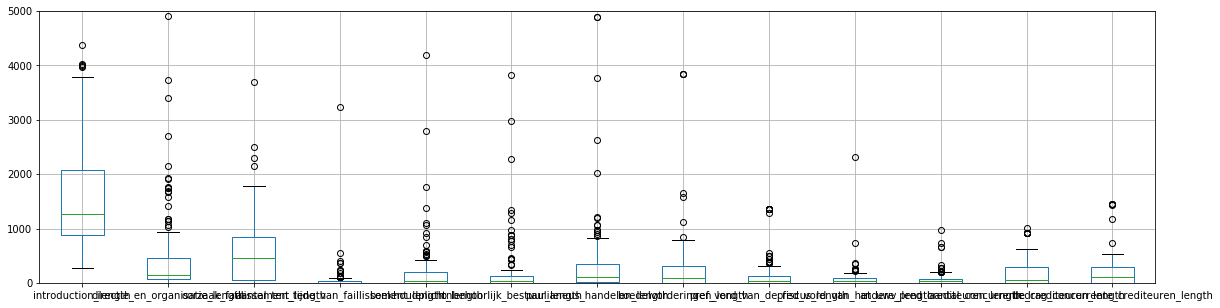

In [71]:
# analyze section length distribution - analyse [false / too long] matches
cols = [col for col in list(df) if 'length' in col and not df[col].isnull().all()]
ax = df.boxplot(column=cols, figsize=(20, 5))
ax.set_ylim(0, 5000)

In [28]:
# test regex on report content
content = df['content']['03_lim_13_41_F_V_02']
pattern = '(?:rechtmatigheid.*?)(paulianeus.*?)(?:\n8)'
match = re.search(pattern, content, re.DOTALL | re.IGNORECASE)
if match:
    print(match.group(1))
else:
    print('no match')

Paulianeus handelen 
Voor  zover  ik  tot  op  heden  heb  kunnen  nagaan,  is  er  geen  sprake  geweest  van  paulianeus 
handelen. 
 
 


In [ ]:
# wens
# use cases
# ontwerp
# evaluatie: hoe goed is het gelukt (ruwe data naar app, sanity checks)
# 2. werkt het: via de use cases.